In [1]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import xarray as xr
from math import ceil,sin,cos, atan2, pi, sqrt
import matplotlib
from matplotlib import pyplot as plt, animation, rc,colors
from datetime import datetime, timedelta
#from cartopy import crs, feature
#import cmocean
import yaml

from IPython.display import Image
rc('animation', html='html5')

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')
from OP_functions23 import *

In [2]:
N = '/home/jvalenti/MOAD/analysis-jose/OParcels/Deploy_locations.csv'
MFc= 1e6
dtp= 10

In [3]:
def pandas_deploy(N,MFc,dtp):
    MFc = float(MFc)
    Rivers_deploy = pd.read_csv(N, index_col = [0])
    Pol = list(Rivers_deploy.Population_polluting)
    Lat = Rivers_deploy.Latitude
    Lon = Rivers_deploy.Longitude
    clat = []
    clon = []
    for i,loc in enumerate(Pol):
        for j in range(int(round((loc*25*dtp)/MFc,0))):
            clat.append(Lat.iat[i])
            clon.append(Lon.iat[i])
    return len(clat)  

In [4]:
pandas_deploy(N,MFc,24)

2651

In [5]:
path_bat = '/home/jvalenti/MOAD/grid/bathymetry_202108.nc'
bat = xr.open_dataset(path_bat,decode_times=False).Bathymetry

In [6]:
path_d='/results2/SalishSea/nowcast-green.202111/30oct22/SalishSea_1h_20221030_20221030_grid_T.nc'
path_d2='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_T.nc'
path_area='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_T.nc'
path_w='/results2/SalishSea/nowcast-green.202111/30oct22/SalishSea_1h_20221030_20221030_grid_W.nc'
path_w2='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_W.nc'
path_u='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_U.nc'
path_v='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_V.nc'

path_mask = '/ocean/jvalenti/MOAD/grid2/mesh_mask202108_TD.nc'
e3t = xr.open_dataset(path_d,decode_times=False).e3t
e3t2 = xr.open_dataset(path_d2,decode_times=False).e3t
e3t = xr.concat([e3t,e3t2],dim='time_counter')
Area = xr.open_dataset(path_area,decode_times=False).area
mbathy = xr.open_dataset(path_mask,decode_times=False).mbathy
zz_ww = xr.open_dataset(path_mask,decode_times=False).gdepw_0
e3t0 = xr.open_dataset(path_mask,decode_times=False).e3t_0

In [7]:
ssh = xr.open_dataset(path_d,decode_times=False).sossheig[:,300,297:302]
ssh2 = xr.open_dataset(path_d2,decode_times=False).sossheig[:,300,297:302]
ssh = xr.concat([ssh,ssh2],dim='time_counter')
mbathy = xr.open_dataset(path_mask,decode_times=False).mbathy[0,300,297:302]
u = xr.open_dataset(path_u,decode_times=False).vozocrtx[:,:,300,297:302]
w = xr.open_dataset(path_w,decode_times=False).vovecrtz[:,:,300,297:302]
w2 = xr.open_dataset(path_w2,decode_times=False).vovecrtz[:,:,300,297:302]
w = xr.concat([w,w2],dim='time_counter')
Kz = xr.open_dataset(path_w,decode_times=False).vert_eddy_diff[:,:,300,297:302]
Kz2 = xr.open_dataset(path_w2,decode_times=False).vert_eddy_diff[:,:,300,297:302]
Kz = xr.concat([Kz,Kz2],dim='time_counter')

depthw = xr.open_dataset(path_w,decode_times=False).depthw
depthu = xr.open_dataset(path_u,decode_times=False).depthu
totaldepth = zz_ww[0, mbathy,300, 297:302]

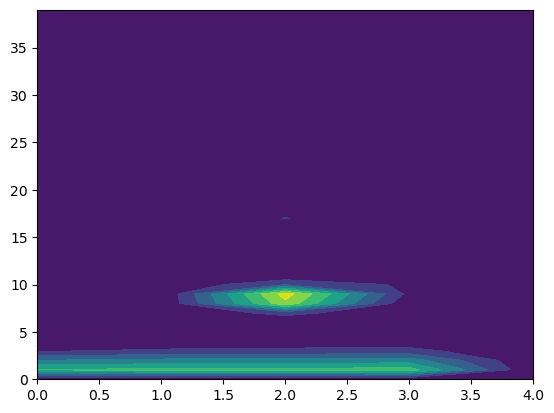

In [8]:
plt.contourf(Kz2[0,:,:])

In [9]:
#Define domain
lon = np.array([250.,750., 1250.,1750.,2250.])
#lonu = np.array([500.,1000., 1500.,2000.,2500])
#latv = np.array([500.,1000.])
#lat = np.array([250.,750])
time = np.linspace(0,2*86400,48)

dim = 5
dep = len(depthu)
t = len(time)

#U = Field('U', u, dtype=np.float32)
#U = Field('U', u, lon=lonu, lat=None, depth=depthu, time=time)
U = Field('U', np.zeros((dep, dim), dtype=np.float32), lon=lon, lat=None, depth=depthu)
V = Field('V', np.zeros((dep, dim), dtype=np.float32), lon=lon, lat=None, depth=depthu)
W = Field('W', w, lon=lon, lat=None, depth=depthw, time=time)
Kz = Field('Kz', Kz, lon=lon, lat=None, depth=depthw, time=time)
SSH = Field('SSH', ssh, lon=lon, lat=None, depth=None, time=time)
Td = Field('TD', totaldepth, lon=lon, lat=None, depth=None, time=None)

In [10]:
fieldset = FieldSet(U,V)
fieldset.add_field(W)
fieldset.add_field(Kz)
fieldset.add_field(SSH)
fieldset.add_field(Td)

In [11]:
class MPParticle(JITParticle):
    fact = Variable('fact', initial =  1.0) 

In [12]:
def DeleteParticle(particle, fieldset, time):
    """Delete particle from OceanParcels simulation to avoid run failure
    """
    
    print(f'Particle {particle.id} lost !! [{particle.time}, {particle.depth}, {particle.lat}, {particle.lon}]')
    particle.delete()

In [13]:
def Advection(particle, fieldset, time):
    ssh = fieldset.SSH[time, particle.depth, particle.lat, particle.lon]
    td = fieldset.TD[time, particle.depth, particle.lat, particle.lon]
    factor = (1+ssh/td)
    particle.fact = factor
    w1 =  fieldset.W[time , particle.depth, particle.lat, particle.lon]
    dep1 = particle.depth + w1*.5*particle.dt
    w2 =  fieldset.W[time + .5 * particle.dt, dep1, particle.lat, particle.lon]
    dep2 = particle.depth + w2*.5*particle.dt
    w3 = fieldset.W[time + .5 * particle.dt, dep2, particle.lat, particle.lon]
    dep3 = particle.depth + w3*particle.dt
    w4 = fieldset.W[time + particle.dt, dep3, particle.lat, particle.lon]
    particle.depth = particle.depth + ((w1 + 2*w2 + 2*w3 + w4) / 6.) * particle.dt

In [14]:
#Mixing Kernel
def Mixing(particle,fieldset,time):
    bath= td
    if particle.depth+0.5 > bath: #upward euler
        Kzdz = 2*(fieldset.Kz[time,particle.depth,particle.lat, particle.lon]-fieldset.Kz[time,particle.depth-0.5,particle.lat, particle.lon]) #forward difference 
    else: #downward euler
        Kzdz = 2*(fieldset.Kz[time,particle.depth+0.5,particle.lat, particle.lon]-fieldset.Kz[time,particle.depth,particle.lat, particle.lon]) #backward difference 
    dgrad = Kzdz * particle.dt 
    if particle.depth+0.5*dgrad > 0 and particle.depth+0.5*dgrad < bath:
        kk = fieldset.Kz[time,particle.depth+0.5*dgrad,particle.lat, particle.lon] #Vertical diffusivity SSC  
    else:
        kk = fieldset.Kz[time, bath,particle.lat, particle.lon] #Vertical diffusivity SSC 
    Rr = ParcelsRandom.uniform(-1, 1)
    d_random = sqrt(3*2*kk*particle.dt) * Rr
    Dlayerz = 0.5*sqrt(kk * particle.dt) #mixing layer
    
    if d_random + dgrad +particle.depth > bath: #randomly in boundary mixed layer
        particle.depth = bath - Dlayerz * ParcelsRandom.uniform(0, 1)
    elif d_random +particle.depth +dgrad < 0:
            particle.depth = Dlayerz * ParcelsRandom.uniform(0, 1) #Well mixed boundary layer
    else:
        particle.depth += d_random + dgrad 

In [15]:
#Mixing Kernel accounting for VVL

def MixingVVL(particle,fieldset,time):
    bath= td
    if particle.depth+0.5/factor > bath: #upward euler
        Kzdz = 2*(fieldset.Kz[time,particle.depth,particle.lat, particle.lon]-fieldset.Kz[time,particle.depth-0.5/factor,particle.lat, particle.lon]) #forward difference 
    else: #downward euler
        Kzdz = 2*(fieldset.Kz[time,particle.depth+0.5/factor,particle.lat, particle.lon]-fieldset.Kz[time,particle.depth,particle.lat, particle.lon]) #backward difference 
    dgrad = Kzdz * particle.dt 
    if particle.depth+0.5*dgrad/factor > 0 and particle.depth+0.5*dgrad/factor < bath:
        kk = fieldset.Kz[time,particle.depth+0.5*dgrad/factor,particle.lat, particle.lon] #Vertical diffusivity SSC  
    else:
        kk = fieldset.Kz[time, particle.depth,particle.lat, particle.lon] #Vertical diffusivity SSC 
    Rr = ParcelsRandom.uniform(-1, 1)
    d_random = sqrt(3*2*kk*particle.dt) * Rr
    Dlayerz = 0.5*sqrt(kk * particle.dt)/factor #mixing layer
    
    if d_random/factor + dgrad/factor +particle.depth > bath: #randomly in boundary mixed layer
        particle.depth = bath - Dlayerz * ParcelsRandom.uniform(0, 1)
    elif d_random/factor +particle.depth +dgrad/factor < 0:
            particle.depth = Dlayerz * ParcelsRandom.uniform(0, 1) #Well mixed boundary layer
    else:
        particle.depth += d_random/factor + dgrad/factor

In [16]:
def AdvectionVVL(particle, fieldset, time):
    ssh = fieldset.SSH[time, particle.depth, particle.lat, particle.lon]
    sshn = fieldset.SSH[time+particle.dt, particle.depth, particle.lat, particle.lon]
    td = fieldset.TD[time, particle.depth, particle.lat, particle.lon]
    factor = (1+ssh/td)
    particle.fact = factor
    wssh = ((sshn-ssh)*particle.depth/(td+ssh))
    w1 =  fieldset.W[time , particle.depth, particle.lat, particle.lon]
    dep1 = particle.depth + w1*.5*particle.dt/factor
    w2 =  fieldset.W[time + .5 * particle.dt, dep1, particle.lat, particle.lon]
    dep2 = particle.depth + w2*.5*particle.dt/factor
    w3 = fieldset.W[time + .5 * particle.dt, dep2, particle.lat, particle.lon]
    dep3 = particle.depth + w3*particle.dt/factor
    w4 = fieldset.W[time + particle.dt, dep3, particle.lat, particle.lon]
    particle.depth = particle.depth + ((w1 + 2*w2 + 2*w3 + w4) / 6.) * particle.dt/factor -wssh

In [17]:
n = 1000
lon_g = np.random.uniform(low=250, high=2000, size=(n,))
depth_g = np.random.uniform(low=0.5, high=20, size=(n,))
lat_g = np.ones(n,)*750
pset = ParticleSet(fieldset, pclass=MPParticle, lon=lon_g, depth=depth_g,lat = lat_g)
pset2 = ParticleSet(fieldset, pclass=MPParticle, lon=lon_g, depth=depth_g,lat = lat_g)
KE=Advection + pset.Kernel(Mixing)
KE2=AdvectionVVL + pset.Kernel(MixingVVL)

output_file = pset.ParticleFile(name='/home/jvalenti/MOAD/results/Output.zarr', outputdt=1200)
output_file2 = pset2.ParticleFile(name='/home/jvalenti/MOAD/results/Output2.zarr', outputdt=1200)
pset.execute(KE , runtime=2*86400, dt=90, output_file=output_file,recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})
pset2.execute(KE2 , runtime=2*86400, dt=90, output_file=output_file2,recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})


INFO: Compiled ArrayMPParticleAdvectionMixing ==> /tmp/parcels-2894/libc00c0a123af58aa34315a3f658b80f1f_0.so


Particle 967 lost !! [74940.0, 1.5926494597806595e-05, 750.0, 1853.27197265625]
Particle 763 lost !! [92760.0, 8.622099994681776e-05, 750.0, 1343.072509765625]
Particle 836 lost !! [93030.0, 1.8553846814484132e-07, 750.0, 1329.3314208984375]
Particle 75 lost !! [96990.0, 3.160583946737461e-05, 750.0, 1931.033935546875]
Particle 998 lost !! [106230.0, 1.537029311293736e-05, 750.0, 1713.1624755859375]


INFO: Output files are stored in /home/jvalenti/MOAD/results/Output.zarr.
100%|██████████| 172800.0/172800.0 [00:04<00:00, 35926.42it/s]  
INFO: Compiled ArrayMPParticleAdvectionVVLMixingVVL ==> /tmp/parcels-2894/lib6bbd772bd0ca56b33d6dade43471f107_0.so


Particle 1219 lost !! [91380.0, 8.359626372111961e-05, 750.0, 860.882080078125]
Particle 1951 lost !! [99300.0, 1.4501330952043645e-05, 750.0, 1028.7879638671875]


INFO: Output files are stored in /home/jvalenti/MOAD/results/Output2.zarr.
 67%|██████▋   | 116400.0/172800.0 [00:00<00:00, 1086031.97it/s]

Particle 1019 lost !! [118410.0, 1.4644407201558352e-05, 750.0, 1498.77978515625]


100%|██████████| 172800.0/172800.0 [00:05<00:00, 30987.73it/s]  


In [18]:
dat = xr.load_dataset('/home/jvalenti/MOAD/results/Output.zarr')
dat2 = xr.load_dataset('/home/jvalenti/MOAD/results/Output2.zarr')

/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [19]:
def anim2(file1,file2,fps=1):  
    fig,axs=plt.subplots(1,1,figsize=(10,5))
    
    axs.set_ylabel('Depth (m)')
    def update(frame):              
        axs.clear()
        axs.axhline(y=0,xmin=250/2250,xmax=2000/2250,c='k')
        axs.axvline(x=250,ymax = 0.91,c='k')
        axs.axvline(x=2000,ymax = 0.91,c='k')
        axs.invert_yaxis()
        axs.set_title("Blue without VVL correction")                 
        axs.scatter(file1.lon[:,frame],-file1.z[:,frame]*file1.fact[:,frame],s=5)
        axs.set_xlim([0,2250])
        axs.set_ylim([-30,5])                
        axs.scatter(file2.lon[:,frame],-file2.z[:,frame]*file2.fact[:,frame],s=5)
                
        return 
    return animation.FuncAnimation(fig, update, frames=np.arange(0,len(file1.lon[0,:]),fps))

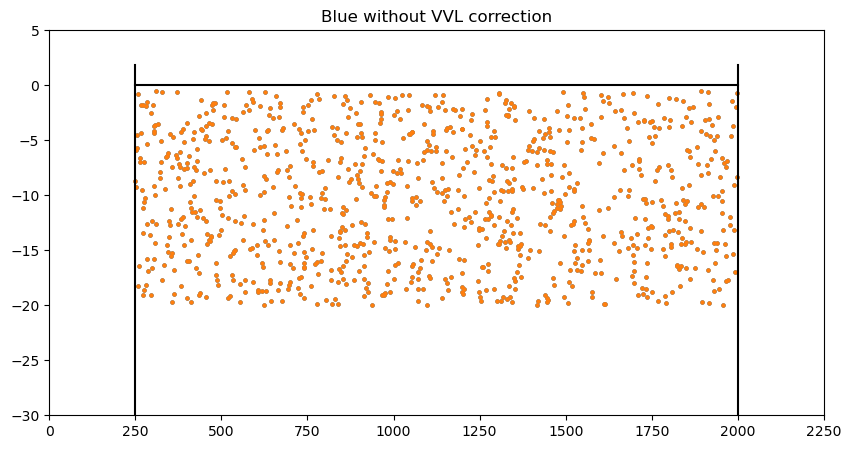

In [20]:
ss =[]
ani = anim2(dat,dat2,fps=1)
f = r"/home/jvalenti/MOAD/animations/box.gif" 
FFwriter = animation.FFMpegWriter()
ani.save(f, writer = FFwriter)

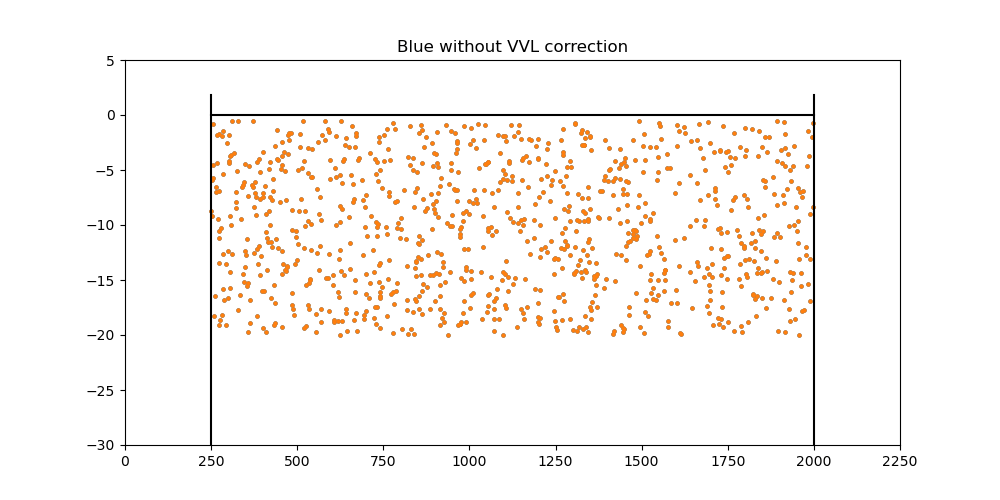

In [21]:
from IPython.display import Image
with open(f,'rb') as anim:
     display(Image(anim.read()))